In [73]:
import os
import pandas as pd
import numpy as np
import torch
import pickle
import onnx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [74]:
def get_data():
  engine_name = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
  engine = create_engine(engine_name)

  query_sql = "SELECT * FROM fb_data"
  df = pd.read_sql_query(query_sql, con=engine)
  return df


In [75]:
class FBData(Dataset):
  def __init__(self,df):

    tokenizer = get_tokenizer('basic_english')
    def yield_tokens(data_iter):
      for text in data_iter:
        yield tokenizer(text)
    vocab = build_vocab_from_iterator(yield_tokens(df['text']), specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])
    
    df.drop(columns=['id'])
    
    self.data = df
    self.vocab = vocab
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = self.data['source'][idx]

    
    tokenized_text = self.vocab(self.tokenizer(text))

    SOURCES = {
      0: ["nytimes","cnn","nbc"],
      1: ["FoxNews","DailyMail","NYPost"],
      2: ["bbcnews","Reuters","APNews"]
    }

    for class_label, sources in SOURCES.items():
        if label in sources:
            label = class_label
            break
    return torch.tensor(tokenized_text),torch.tensor(label)

def collate_batch(batch):
  text_list=[]
  label_list=[]
  for text,label in batch:
    text_list.append(text)
    label_list.append(label)

  padded_texts = pad_sequence(text_list,batch_first=True,padding_value=0)
  return padded_texts, label_list

In [76]:
class BiasClassificationModel(nn.Module):
  def __init__(self,vocab_size,embed_dim,num_class):
    super(BiasClassificationModel,self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size,embed_dim,sparse=False)
    self.fc = nn.Linear(embed_dim,num_class)

  
  def forward(self,text):
    embedded = self.embedding(text)
    return self.fc(embedded)

In [77]:
def split_data(dataset,batch_size):
  train_idx, test_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42,shuffle=True)
  train_dataset = Subset(dataset,train_idx)
  test_dataset = Subset(dataset,test_idx)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  return train_loader, test_loader

In [78]:
def train(dataloader,model,optimizer,criterion,verbose):
  model.train()
  train_loss = 0
  train_acc = 0

  for text,label in tqdm(dataloader, disable=not verbose):
    optimizer.zero_grad()

    output = model(text)
    loss = criterion(output,label)
    train_loss += loss.item()
    train_acc += (output.argmax(1) == label).sum().item()
    loss.backward()
    optimizer.step()

  train_loss/=len(dataloader)
  train_acc/=len(dataloader)

  return train_loss, train_acc, model, optimizer, criterion

def test(dataloader,model,criterion, verbose):
  model.eval()
  test_loss = 0
  test_acc = 0

  with torch.no_grad():
    for text,label in tqdm(dataloader,disable=not verbose):
      output = model(text)
      loss = criterion(output,label)
      test_loss += loss.item()
      test_acc += (output.argmax(1) == label).sum().item()
      
  test_loss/=len(dataloader)
  test_acc/=len(dataloader)
  return test_loss,test_acc

def train_test_loop(train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose):
  print('Training Starting')

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
    train_loss, train_acc, model, optimizer, criterion = train(train_loader,model,optimizer,criterion,verbose)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    if verbose: print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    test_loss, test_acc  = test(test_loader,model,criterion,verbose)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if verbose: print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
  
  plt.plot(train_losses,label='Train Loss')
  plt.plot(test_losses,label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_accs,label='Train Acc')
  plt.plot(test_accs,label='Test Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.legend()
  plt.show()



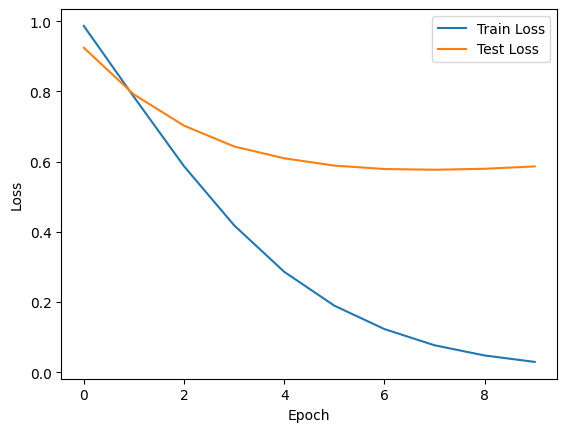

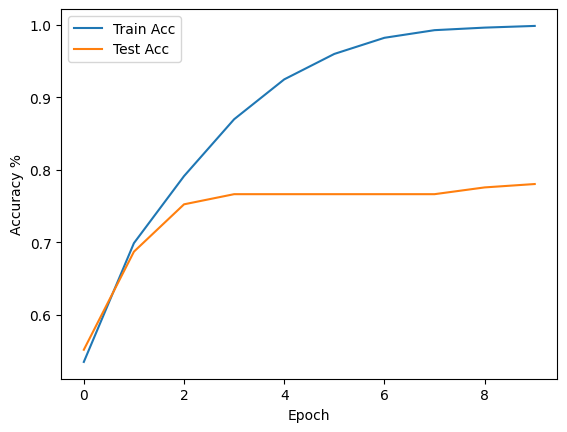

In [79]:
def main(batch_size,num_epochs,verbose):
  df = get_data()
  dataset = FBData(df)
  train_loader, test_loader = split_data(dataset,batch_size)

  model = BiasClassificationModel(len(dataset.vocab),64,3)
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  criterion = torch.nn.CrossEntropyLoss()

  train_test_loop(train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)


main(batch_size=1,num_epochs=10,verbose=False) 
  